### 할당된 GPU 확인

In [1]:
!nvidia-smi

Tue Jun 15 02:42:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Drive mount

In [2]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')

Mounted at /content/drive


### 필요한 library 및 자료 다운로드

In [3]:
!pip install  mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 46.9MB 127kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 3.8MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595698 sha256=bef1576b6885f5922acb31bcd28ee1b572013979cafb28023291fba0fc3de858
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 3.9MB/s 
     |████████████████████████████████| 2.3MB 4.0MB/s 
     |████████████████████████████████| 3.3MB 27.7MB/s 
     |████████████████████████████████| 901kB 41.1MB/s 


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [6]:
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

### gpu 사용

In [7]:
##GPU 사용 시
device = torch.device("cuda:0")

### Pretrained bert, vocab download
####vocab은 문장에 있는 단어 나눌 때 사용됨, 형태소 사전같은 걸로 생각하면 된다

In [8]:
#bertmodel, vocab = get_pytorch_kobert_model()
#bertmodel = get_kobert_model()

model_path = '/content/drive/MyDrive/kobert_from_pretrained'
vocab_file = '/content/drive/MyDrive/kobert_news_wiki_ko_cased-1087f8699e.spiece'
bertmodel = BertModel.from_pretrained(model_path)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file, padding_token='[PAD]')

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### 우리가 사용하는 dataset 가져와서 train, validation, test set으로 분류

In [10]:
file1 = '/content/drive/MyDrive/problem_ner_multilabel_re_addonlykorean_replacevariable_replacenumber.csv'
file2 = '/content/drive/MyDrive/problem_ner_min_re_275_addonlykorean_replacevariable_replacenumber.csv'
file3 = '/content/drive/MyDrive/ner_preprocessed_complete_re_drop_addonlykorean_replacevariable_replacenumber_8_label_single.csv'

In [11]:
df = pd.read_csv(file3)

In [12]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'id', 'tag', 'title', 'description', 'input', 'output', 'ner_decode',
       'list_ner', 'ner_preprocessed_desc', 'only_korean_desc',
       'only_korean_input', 'only_korean_output',
       'only_korean_variablenumber_desc', 'only_korean_variablenumber_input',
       'only_korean_variablenumber_output', 'variablenumber_desc',
       'variablenumber_input', 'variablenumber_output',
       'desc_variabel_renumber', 'input_variabel_renumber',
       'output_variabel_renumber', 'desc_variabel_renumber_0',
       'input_variabel_renumber_0', 'output_variabel_renumber_0'],
      dtype='object')

In [13]:
train_df, remaining = train_test_split(df, random_state = 46, train_size = 0.7, stratify = df.tag.values)
valid_df, test_df = train_test_split(remaining, random_state=46, train_size = 0.5, stratify = remaining.tag.values)

### tag가 string이기 때문에 숫자로 바꾸기 위해서 encoder라는 것을 사용한다
### encoder를 사용하면 쉽게 tag의 문자를 숫자로 바꿔준다

In [14]:
print(train_df.shape, valid_df.shape, test_df.shape)

#라벨의 숫자화
label = df['tag'].values
encoder = LabelEncoder()
encoder.fit(label)

(2842, 31) (609, 31) (609, 31)


LabelEncoder()

### label별 data 개수가 불균형한 경우 학습에 영향을 주기 때문에 loss 가중치를 조정하여 해결할 수도 있다
### 우리 학습할 땐 사용 안했음

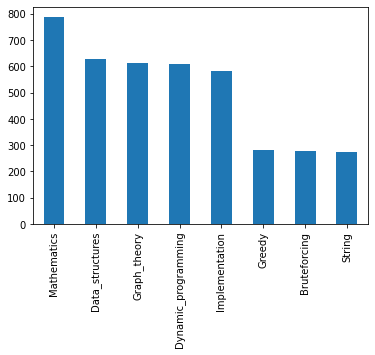

['Bruteforcing' 'Data_structures' 'Dynamic_programming' 'Graph_theory'
 'Greedy' 'Implementation' 'Mathematics' 'String']
tensor([1.8255, 0.8068, 0.8333, 0.8279, 1.7933, 0.8690, 0.6440, 1.8388])


In [15]:
df.tag.value_counts().plot(kind='bar')
plt.show()

class_loss = [df.tag.value_counts()[i] for i in encoder.classes_ ]
class_weights = compute_class_weight('balanced', np.unique(df['tag']), df['tag'])
weights= torch.tensor(class_weights,dtype=torch.float)
print(encoder.classes_)
print(weights)

In [16]:
### 분류한 dataset을 형식에 맞게 변환하는 코드

In [17]:
def set_data(dataframe) :
  dataset = []
  tmp = encoder.transform(dataframe['tag'])
  i = 0
  for index, row in dataframe.iterrows():
   problem = row['desc_variabel_renumber_0']
   if not pd.isna(row['input_variabel_renumber_0']) :
      problem = problem + row['input_variabel_renumber_0']

   dataset.append([problem , tmp[i]])
   i = i + 1
  return dataset

In [18]:
dataset_train = set_data(train_df)
dataset_valid = set_data(valid_df)
dataset_test = set_data(test_df)

### tokenizer는 문장을 단어로 나눠주는 역할을 한다

In [19]:
#tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(vocab_file, vocab, lower=False)

### 데이터셋 정리

In [20]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


### model parameter


In [21]:
## Setting parameters
max_len = 512
batch_size = 8
warmup_ratio = 0.1
num_epochs = 8
max_grad_norm = 1
log_interval = 50
learning_rate =  5e-5

### 데이터 셋 표준화 과정

In [22]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [23]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 우리가 사용할 모델 정의 
### bert 모델 뒤에 single layer 추가해서 softmax로 분류하는 방식

In [32]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
        self.classifier = nn.Linear(8096, num_classes)
        #16, 8096
        #32, 16192
        self.kernel_num = 16
        self.conv1d_maxpooling1 = nn.Sequential(
            nn.Conv1d(hidden_size, self.kernel_num, 4, stride = 2),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.Dropout(dr_rate)
        )
        self.conv1d_maxpooling2 = nn.Sequential(
            nn.Conv1d(hidden_size, self.kernel_num,8, stride = 2),
            nn.ReLU(),
            nn.MaxPool1d(2, 1),
            nn.Dropout(dr_rate)
        )

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        op, _ = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)

        out1 = self.conv1d_maxpooling1(op.transpose(1, 2))
        out2 = self.conv1d_maxpooling2(op.transpose(1, 2))
        out = torch.cat((out1, out2), 2)
        out = out.reshape(out.size(0), -1)
        
        return  self.classifier(out)

### model 할당

In [33]:
model = BERTClassifier(bertmodel, num_classes=8, dr_rate=0.1).to(device) 

In [34]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01}, #0.01
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0} #0.0
]

### optimizer와 loss function 설정

In [35]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight = weights).to(device)
#loss_fn = nn.CrossEntropyLoss()

In [36]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [37]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [38]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# train


In [39]:
train_loss_values = []
validation_loss_values = [] 
train_acc_list = []
validation_acc_list = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0

    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule

        train_loss += loss.item()
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(train_loss)
    train_acc_list.append(train_acc / len(train_dataloader))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        
        validation_loss += loss.item() 
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    validation_loss = validation_loss / len(valid_dataloader)
    validation_loss_values.append(validation_loss)
    validation_acc_list.append(test_acc / len(valid_dataloader))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0822949409484863 train acc 0.125
epoch 1 batch id 51 loss 1.995261311531067 train acc 0.16911764705882354
epoch 1 batch id 101 loss 2.1863670349121094 train acc 0.17202970297029702
epoch 1 batch id 151 loss 1.93748140335083 train acc 0.19701986754966888
epoch 1 batch id 201 loss 1.970740556716919 train acc 0.208955223880597
epoch 1 batch id 251 loss 2.142251491546631 train acc 0.2106573705179283
epoch 1 batch id 301 loss 1.898683786392212 train acc 0.2180232558139535
epoch 1 batch id 351 loss 1.976635456085205 train acc 0.2222222222222222

epoch 1 train acc 0.22226123595505617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 1 test acc 0.2418831168831169


epoch 2 batch id 1 loss 2.052044630050659 train acc 0.25
epoch 2 batch id 51 loss 1.8283979892730713 train acc 0.2818627450980392
epoch 2 batch id 101 loss 1.9960792064666748 train acc 0.27722772277227725
epoch 2 batch id 151 loss 1.7568503618240356 train acc 0.29718543046357615
epoch 2 batch id 201 loss 1.8081156015396118 train acc 0.2960199004975124
epoch 2 batch id 251 loss 1.794490933418274 train acc 0.28436254980079684
epoch 2 batch id 301 loss 1.7229037284851074 train acc 0.2799003322259136
epoch 2 batch id 351 loss 1.9734007120132446 train acc 0.275997150997151

epoch 2 train acc 0.2749297752808989



epoch 2 test acc 0.3003246753246753


epoch 3 batch id 1 loss 1.8958215713500977 train acc 0.125
epoch 3 batch id 51 loss 1.714385747909546 train acc 0.3014705882352941
epoch 3 batch id 101 loss 1.9091447591781616 train acc 0.32301980198019803
epoch 3 batch id 151 loss 1.644361138343811 train acc 0.3352649006622517
epoch 3 batch id 201 loss 1.6904211044311523 train acc 0.3302238805970149
epoch 3 batch id 251 loss 1.7748831510543823 train acc 0.3157370517928287
epoch 3 batch id 301 loss 1.7595866918563843 train acc 0.3168604651162791
epoch 3 batch id 351 loss 1.777949571609497 train acc 0.31445868945868943

epoch 3 train acc 0.31495786516853935



epoch 3 test acc 0.3457792207792208


epoch 4 batch id 1 loss 2.0080482959747314 train acc 0.25
epoch 4 batch id 51 loss 1.4110130071640015 train acc 0.3431372549019608
epoch 4 batch id 101 loss 1.7498468160629272 train acc 0.349009900990099
epoch 4 batch id 151 loss 1.650587558746338 train acc 0.35016556291390727
epoch 4 batch id 201 loss 1.8718844652175903 train acc 0.35696517412935325
epoch 4 batch id 251 loss 1.4785102605819702 train acc 0.35856573705179284
epoch 4 batch id 301 loss 1.8803071975708008 train acc 0.3617109634551495
epoch 4 batch id 351 loss 1.6255829334259033 train acc 0.36716524216524216

epoch 4 train acc 0.3655196629213483



epoch 4 test acc 0.349025974025974


epoch 5 batch id 1 loss 2.572805404663086 train acc 0.125
epoch 5 batch id 51 loss 1.06093168258667 train acc 0.42401960784313725
epoch 5 batch id 101 loss 1.9728467464447021 train acc 0.4207920792079208
epoch 5 batch id 151 loss 1.453745722770691 train acc 0.4461920529801324
epoch 5 batch id 201 loss 1.8195141553878784 train acc 0.4465174129353234
epoch 5 batch id 251 loss 0.9122436046600342 train acc 0.4447211155378486
epoch 5 batch id 301 loss 1.8341803550720215 train acc 0.44975083056478404
epoch 5 batch id 351 loss 1.6354111433029175 train acc 0.46296296296296297

epoch 5 train acc 0.46348314606741575



epoch 5 test acc 0.3409090909090909


epoch 6 batch id 1 loss 2.0330629348754883 train acc 0.25
epoch 6 batch id 51 loss 0.7425827383995056 train acc 0.5220588235294118
epoch 6 batch id 101 loss 2.0518620014190674 train acc 0.5371287128712872
epoch 6 batch id 151 loss 0.8748160600662231 train acc 0.5438741721854304
epoch 6 batch id 201 loss 1.6840108633041382 train acc 0.5422885572139303
epoch 6 batch id 251 loss 0.715275228023529 train acc 0.5403386454183267
epoch 6 batch id 301 loss 1.57099187374115 train acc 0.5431893687707641
epoch 6 batch id 351 loss 1.3632391691207886 train acc 0.5555555555555556

epoch 6 train acc 0.557935393258427



epoch 6 test acc 0.36038961038961037


epoch 7 batch id 1 loss 1.7658140659332275 train acc 0.5
epoch 7 batch id 51 loss 0.4017696976661682 train acc 0.625
epoch 7 batch id 101 loss 1.6827847957611084 train acc 0.6311881188118812
epoch 7 batch id 151 loss 0.9210869073867798 train acc 0.6349337748344371
epoch 7 batch id 201 loss 1.1488171815872192 train acc 0.6368159203980099
epoch 7 batch id 251 loss 0.4517635703086853 train acc 0.6384462151394422
epoch 7 batch id 301 loss 1.5013536214828491 train acc 0.6453488372093024
epoch 7 batch id 351 loss 1.103181004524231 train acc 0.6556267806267806

epoch 7 train acc 0.6569522471910112



epoch 7 test acc 0.3685064935064935


epoch 8 batch id 1 loss 1.379296064376831 train acc 0.625
epoch 8 batch id 51 loss 0.19647398591041565 train acc 0.7034313725490197
epoch 8 batch id 101 loss 1.7251648902893066 train acc 0.7004950495049505
epoch 8 batch id 151 loss 0.6284570097923279 train acc 0.7077814569536424
epoch 8 batch id 201 loss 1.0815845727920532 train acc 0.7058457711442786
epoch 8 batch id 251 loss 0.4260416030883789 train acc 0.7061752988047809
epoch 8 batch id 301 loss 1.1112786531448364 train acc 0.7142857142857143
epoch 8 batch id 351 loss 0.9216338992118835 train acc 0.7254273504273504

epoch 8 train acc 0.7268258426966292



epoch 8 test acc 0.3814935064935065


### loss graph

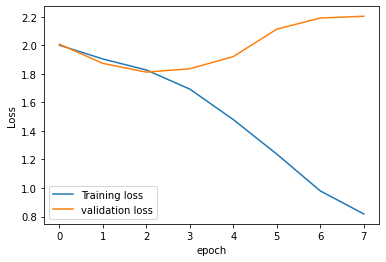

In [40]:
plt.plot(np.array(train_loss_values), label='Training loss')
plt.plot(np.array(validation_loss_values), label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 정확도 graph


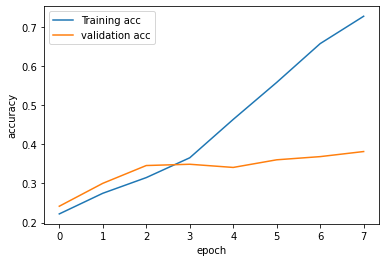

In [41]:
plt.plot(np.array(train_acc_list), label='Training acc')
plt.plot(np.array(validation_acc_list), label='validation acc')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### predict

In [45]:
pred_list = []
test_label = []

with torch.no_grad():
  model.eval()
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    test_label.extend(label)
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    _, pred_value = torch.max(out, 1)
    pred_list.extend(pred_value.cpu().numpy())

pred_list = [a.squeeze().tolist() for a in pred_list]
test_label = [a.squeeze().tolist() for a in test_label]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 알고리즘별 정확도 출력하는 코드
#### precision : label이 a일 때 a라고 예측한 확률
#### recall : a라고 예측했을 때, a인 확률
#### f1-score : recall과 precision의 조화평균
#### support : 개수
#### 관점에 따라 사용하는 것이 다르다고 생각하면 됨 

In [46]:
target_name = encoder.classes_
print(classification_report(test_label, pred_list, target_names=target_name, zero_division = 0))

                     precision    recall  f1-score   support

       Bruteforcing       0.18      0.24      0.21        42
    Data_structures       0.52      0.49      0.50        94
Dynamic_programming       0.27      0.31      0.29        91
       Graph_theory       0.51      0.58      0.54        92
             Greedy       0.14      0.19      0.16        42
     Implementation       0.42      0.31      0.35        88
        Mathematics       0.56      0.42      0.48       118
             String       0.51      0.62      0.56        42

           accuracy                           0.41       609
          macro avg       0.39      0.39      0.39       609
       weighted avg       0.43      0.41      0.41       609



### y축 = input x축 = 예측 결과, 대각선의 확률이 a일 때 a로 예측한 확률

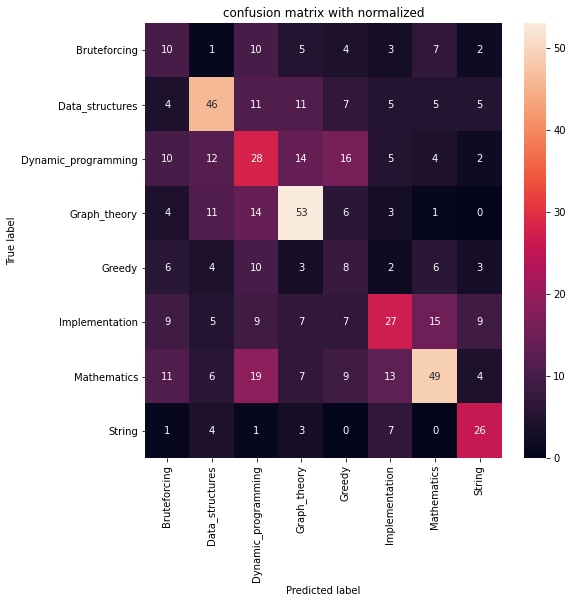

In [48]:
cm = confusion_matrix(test_label, pred_list)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, target_name, target_name)
plt.figure(figsize=(8, 8))
plt.title('confusion matrix with normalized')
sn.heatmap(df_cm, annot = True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()